In [3]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format',lambda x : '%.5f' % x)
pd.set_option('display.width', 500)    #设置整体宽度
from mtools import plot_fig
import matplotlib.pyplot as plt
import seaborn as sns
from mtools import monkey as mk

os.chdir('/data/wjk/Workspace/Datasets/IGR')
IGR_DIRS = ['IGR_cjy', 'IGR230307', 'IGR230312', 'IGR230415']
IGR_DIR = 'IGR230415'

In [4]:
all_imu_data = pd.read_hdf(f'Output/all_imu_data_{IGR_DIR}.h5', 'all_imu')
phones = all_imu_data['phone'].unique()
trips = all_imu_data['trip'].unique()
all_imu_data['AccU'] = all_imu_data['AccU'] - 9.8

In [29]:
all_imu_data.columns

Index(['timestamp', 'elapsedRealtimeNanos', 'AccX', 'AccY', 'AccZ', 'Source',
       'AccE', 'AccN', 'AccU', 'GysX', 'GysY', 'GysZ', 'GysE', 'GysN', 'GysU',
       'MagX', 'MagY', 'MagZ', 'yawDeg', 'rollDeg', 'pitchDeg', 'phone',
       'trip'],
      dtype='object')

In [17]:
# Normalization
for IGR_DIR in IGR_DIRS:
    all_imu_data = pd.read_hdf(f'Output/all_imu_data_{IGR_DIR}.h5', 'all_imu')
    phones = all_imu_data['phone'].unique()
    trips = all_imu_data['trip'].unique()
    all_imu_data['AccU'] = all_imu_data['AccU'] - 9.8
    acc_values = all_imu_data[['timestamp', 'AccE', 'AccN', 'AccU']].melt(id_vars=['timestamp'], value_vars=['AccE', 'AccN', 'AccU'])['value']
    gyr_values = all_imu_data[['timestamp', 'GysE', 'GysN', 'GysU']].melt(id_vars=['timestamp'], value_vars=['GysE', 'GysN', 'GysU'])['value']
    acc_values = np.abs(acc_values)
    gyr_values = np.abs(gyr_values)
    acc_des = acc_values.astype('float64').describe(percentiles=[.01, 0.1, 0.2, .25, .75, .8, 0.9, 0.99]).to_frame().T
    gyr_des = gyr_values.astype('float64').describe(percentiles=[.01, 0.1, 0.2, .25, .75, .8, 0.9, 0.99]).to_frame().T
    mk.magic_append([acc_des, gyr_des])
acc_des_list, gyr_des_list = mk.magic_get()

In [18]:
acc_des = pd.concat(acc_des_list)
gyr_des = pd.concat(gyr_des_list)
print(acc_des)
print(gyr_des)
print(acc_des/gyr_des)

pd.concat((acc_des, gyr_des, acc_des/gyr_des)).to_csv('Output/acc_gyr_des.csv', float_format='%.2f')

              count    mean     std     min      1%     10%     20%     25%     50%     75%     80%     90%     99%      max
value 2285604.00000 0.68313 0.52671 0.00000 0.01062 0.10613 0.21337 0.26778 0.56428 0.98404 1.10592 1.43979 2.22519  4.86103
value 1768122.00000 1.32696 1.04526 0.00000 0.02038 0.20418 0.40839 0.51173 1.07079 1.90073 2.15465 2.86765 4.38663  9.68904
value 2062416.00000 1.32259 1.13838 0.00000 0.01926 0.19337 0.38581 0.48210 0.99112 1.85422 2.16092 2.99375 4.95650 10.24659
              count    mean     std     min      1%     10%     20%     25%     50%     75%     80%     90%     99%     max
value 2285604.00000 0.15861 0.15137 0.00000 0.00213 0.02145 0.04340 0.05469 0.11838 0.21313 0.24267 0.33954 0.73618 1.85722
value 1768122.00000 0.27039 0.21441 0.00000 0.00431 0.04347 0.08665 0.10838 0.22185 0.37669 0.42368 0.56532 0.95877 1.84387
value 2062416.00000 0.23153 0.18213 0.00000 0.00355 0.03588 0.07225 0.09078 0.19159 0.32954 0.36876 0.47978 0.80734 1.72785
    

In [9]:
trip_id = 0
phones = all_imu_data['phone'].unique()
# phones = phones[1:3]
phones = ['Mate30']
pre_duration = 0
duration = 20
sub_dfs = [all_imu_data['timestamp'][(all_imu_data['trip']==trips[trip_id])&(all_imu_data['phone']==phone)].to_frame() for phone in phones]
print(len(sub_dfs))
start_timestamps = [sub_df.iloc[0] for sub_df in sub_dfs]
start_timestamp = np.max(start_timestamps) + pre_duration*100
start_timestamp_inds = [np.where(sub_df==start_timestamp)[0][0] for sub_df in sub_dfs]
print(start_timestamp_inds)
sub_dfs = [all_imu_data[(all_imu_data['trip']==trips[trip_id])&(all_imu_data['phone']==phone)].iloc[ind:ind+duration*100] for phone,ind in zip(phones, start_timestamp_inds)]
sub_df = pd.concat(sub_dfs)

1
[0]


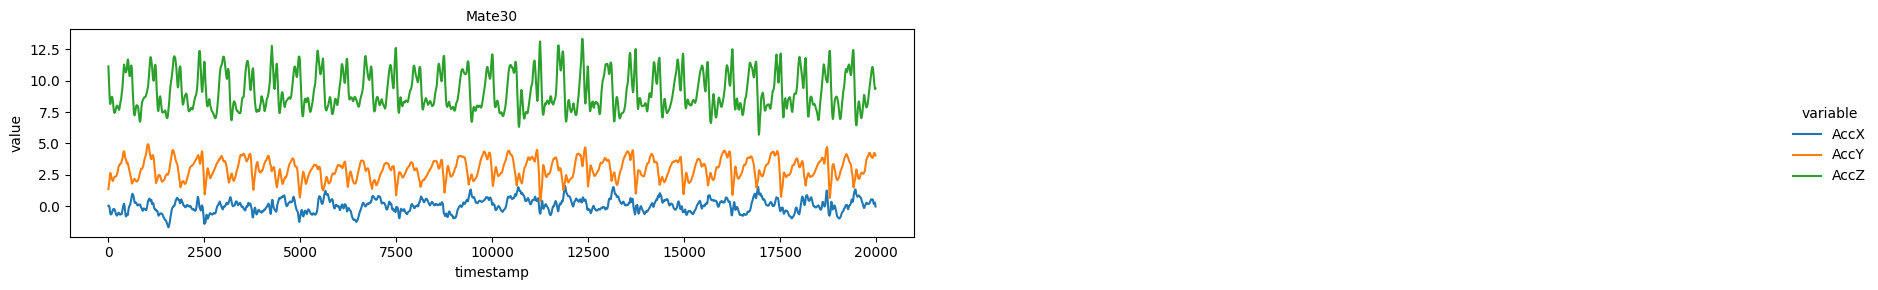

In [10]:
melt_sub_df = pd.melt(sub_df[['timestamp', 'AccX', 'AccY', 'AccZ', "phone"]], id_vars=['timestamp', 'phone'], value_vars=['AccX', 'AccY', 'AccZ'])
melt_sub_df['timestamp'] = melt_sub_df['timestamp']-np.min(melt_sub_df['timestamp'].values)

g = sns.FacetGrid(melt_sub_df, hue='variable', col="phone",  col_wrap=2, despine=False, aspect=3)
g.map(sns.lineplot, "timestamp", "value")
g.set_titles("{col_name}")
g.add_legend()
plt.show()
# g.savefig('Figures/err_scatter_byphone_new.png', dpi=150, pad_inches=0.2)

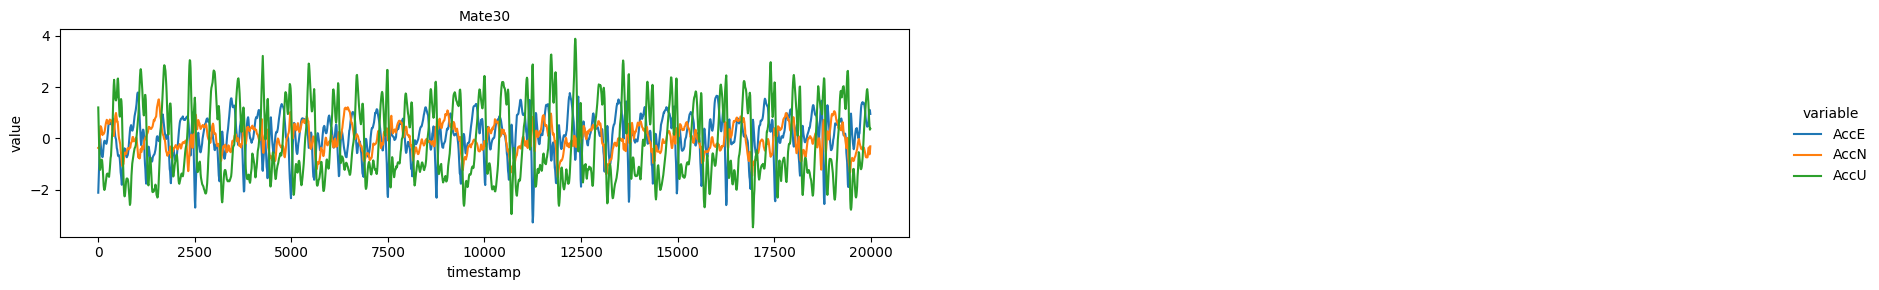

In [11]:
melt_sub_df = pd.melt(sub_df[['timestamp', 'AccE', 'AccN', 'AccU', "phone"]], id_vars=['timestamp', 'phone'], value_vars=['AccE', 'AccN', 'AccU'])
melt_sub_df['timestamp'] = melt_sub_df['timestamp']-np.min(melt_sub_df['timestamp'].values)
g = sns.FacetGrid(melt_sub_df, hue='variable', col="phone",  col_wrap=2, despine=False, aspect=3)
g.map(sns.lineplot, "timestamp", "value")
g.set_titles("{col_name}")
g.add_legend()
plt.show()

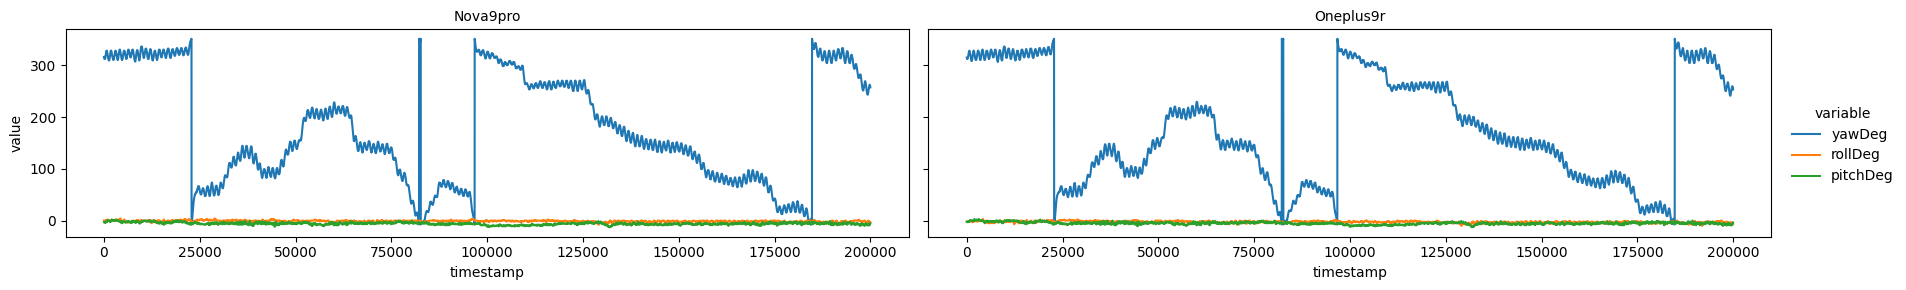

In [20]:
melt_sub_df = pd.melt(sub_df[['timestamp', 'yawDeg', 'rollDeg', 'pitchDeg', "phone"]], id_vars=['timestamp', 'phone'], value_vars=['yawDeg', 'rollDeg', 'pitchDeg'])
melt_sub_df['timestamp'] = melt_sub_df['timestamp']-np.min(melt_sub_df['timestamp'].values)

g = sns.FacetGrid(melt_sub_df, hue='variable', col="phone",  col_wrap=2, despine=False, aspect=3)
g.map(sns.lineplot, "timestamp", "value")
g.set_titles("{col_name}")
g.add_legend()
plt.show()
# g.savefig('Figures/err_scatter_byphone_new.png', dpi=150, pad_inches=0.2)

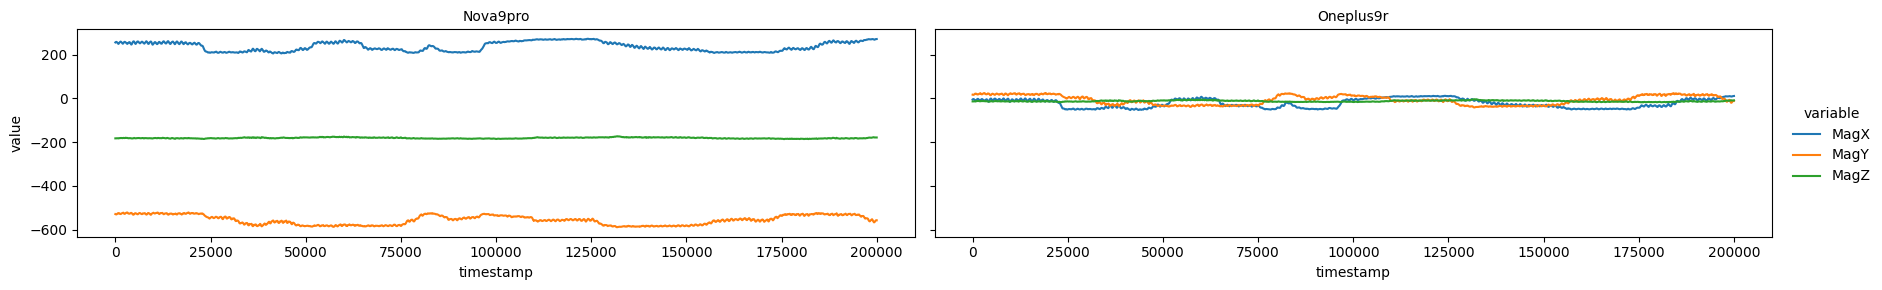

In [21]:
melt_sub_df = pd.melt(sub_df[['timestamp', 'MagX', 'MagY', 'MagZ', "phone"]], id_vars=['timestamp', 'phone'], value_vars=['MagX', 'MagY', 'MagZ'])
melt_sub_df['timestamp'] = melt_sub_df['timestamp']-np.min(melt_sub_df['timestamp'].values)

g = sns.FacetGrid(melt_sub_df, hue='variable', col="phone",  col_wrap=2, despine=False, aspect=3)
g.map(sns.lineplot, "timestamp", "value")
g.set_titles("{col_name}")
g.add_legend()
plt.show()
# g.savefig('Figures/err_scatter_byphone_new.png', dpi=150, pad_inches=0.2)